### Чтение шрифтов из папки fonts

In [1]:
import os

def find_fonts(folder_path):
    font_paths = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.ttf', '.otf')):
                font_paths.append(os.path.join(root, file))

    return font_paths


folder_path = 'fonts'
font_paths = find_fonts(folder_path)

print(font_paths)


['fonts/Aguante/Aguante-Regular.otf', 'fonts/Ghastly Panic/GhastlyPanicCyr.otf', 'fonts/Brass Mono/BrassMono-Regular.ttf', 'fonts/Brass Mono/BrassMono-Italic.ttf', 'fonts/Brass Mono/BrassMono-BoldItalic.ttf', 'fonts/Brass Mono/BrassMono-Bold.ttf', 'fonts/Better VCR/better-vcr-5.2.ttf', 'fonts/Sans Collegiate One/AlumniSansCollegiateOne-Italic.ttf', 'fonts/Sans Collegiate One/AlumniSansCollegiateOne-Regular.ttf', 'fonts/Ganesha Type/GaneshaType-Regular.ttf', 'fonts/Tana Uncial SP/TanaUncialSP.otf', 'fonts/Realest/Realest-Extended.otf', 'fonts/Aref Ruqaa Ink/ArefRuqaaInk-Regular.ttf', 'fonts/Aref Ruqaa Ink/ArefRuqaaInk-Bold.ttf', 'fonts/Ambidexter/ambidexter_regular.otf']


In [2]:
print(len(font_paths))

15


### Генерация обучающей и тестовой выборки на основании шрифтов

In [3]:
#!pip install pillow

In [4]:
from PIL import Image, ImageDraw, ImageFont
import random
import os

#пути для сохранения наборов данных
train_path = 'train_data'
test_path = 'test_data'

#папки для обучающего и тестового наборов данных
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

#список символов английского алфавита, которые могут появляться на изображениях
characters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

#функция для создания изображения с текстом и указанным шрифтом
def create_image(font_path, text, image_size=(200, 100), text_position=(10, 10), font_size=40):
    image = Image.new('RGB', image_size, 'white')
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype(font_path, font_size)
    draw.text(text_position, text, font=font, fill='black')
    return image

#класс для каждого шрифта
class FontDataset:
    def __init__(self, font_path):
        self.font_path = font_path
        self.train_path = os.path.join(train_path, os.path.basename(font_path).replace(' ', '_').replace('/', '_'))
        self.test_path = os.path.join(test_path, os.path.basename(font_path).replace(' ', '_').replace('/', '_'))
        os.makedirs(self.train_path, exist_ok=True)
        os.makedirs(self.test_path, exist_ok=True)

    def generate_dataset(self, num_samples=100):
        for _ in range(num_samples):
            #добавлять в обучающий или тестовый набор данных
            dataset_path = self.train_path if random.random() < 0.8 else self.test_path

            #генерация случайного текста с 1-5 символами
            text_length = random.randint(1, 5)
            text = ''.join(random.choice(characters) for _ in range(text_length))

            #создание изображения с указанным шрифтом и сохранение
            image = create_image(self.font_path, text)
            image_name = f"{text}_{os.path.basename(self.font_path).replace(' ', '_').replace('/', '_')}.png"
            image.save(os.path.join(dataset_path, image_name))

#создание объекта FontDataset для каждого шрифта и генерация набора данных
for font_path in font_paths:
    font_dataset = FontDataset(font_path)
    font_dataset.generate_dataset(num_samples=100)  # 100 образцов


### Модуль обучения

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os
import csv

#параметры нейросети (можно захардкодить или передавать извне)
input_shape = (200, 100, 3)
num_classes = 15
epochs = 10
batch_size = 32

#создание нейросети
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

#компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#загрузка данных
train_data_dir = 'train_data'
test_data_dir = 'test_data'

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

#обучение нейросети
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

#логгирование ошибок
log_file = 'training_log.csv'

with open(log_file, 'w', newline='') as csvfile:
    fieldnames = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for epoch in range(epochs):
        writer.writerow({
            'epoch': epoch + 1,
            'train_loss': history.history['loss'][epoch],
            'train_accuracy': history.history['accuracy'][epoch],
            'val_loss': history.history['val_loss'][epoch],
            'val_accuracy': history.history['val_accuracy'][epoch]
        })


2024-01-30 00:33:21.604023: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-30 00:33:25.612098: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 1146 images belonging to 15 classes.
Found 276 images belonging to 15 classes.
Epoch 1/10
35/35 [==============================] - 12s 315ms/step - loss: 8.2486 - accuracy: 0.2926 - val_loss: 1.2208 - val_accuracy: 0.6953
Epoch 2/10
35/35 [==============================] - 11s 308ms/step - loss: 0.7429 - accuracy: 0.7720 - val_loss: 0.5602 - val_accuracy: 0.7969
Epoch 3/10
35/35 [==============================] - 11s 307ms/step - loss: 0.3726 - accuracy: 0.8680 - val_loss: 0.4569 - val_accuracy: 0.8086
Epoch 4/10
35/35 [==============================] - 11s 307ms/step - loss: 0.2312 - accuracy: 0.9417 - val_loss: 0.3299 - val_accuracy: 0.8828
Epoch 5/10
35/35 [==============================] - 11s 310ms/step - loss: 0.1482 - accuracy: 0.9749 - val_loss: 0.2736 - val_accuracy: 0.9023
Epoch 6/10
35/35 [==============================] - 11s 309ms/step - loss: 0.1052 - accuracy: 0.9847 - val_loss: 0.2300 - val_accuracy: 0.9375
Epoch 7/10
35/35 [==============================] - 11s 3

### Оценка основных метрик классификации

/Users/k18/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  after removing the cwd from sys.path.


Evaluation Loss: 0.20763172209262848
Evaluation Accuracy: 0.9311594367027283


/Users/k18/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.07      0.08        28
           1       0.00      0.00      0.00        16
           2       0.15      0.13      0.14        31
           3       0.06      0.09      0.07        11
           4       0.00      0.00      0.00        17
           5       0.06      0.06      0.06        18
           6       0.06      0.06      0.06        18
           7       0.00      0.00      0.00        15
           8       0.13      0.12      0.13        16
           9       0.10      0.10      0.10        20
          10       0.00      0.00      0.00        14
          11       0.07      0.06      0.07        16
          12       0.24      0.21      0.22        19
          13       0.06      0.06      0.06        17
          14       0.00      0.00      0.00         0

    accuracy                           0.07       256
   macro avg       0.07      0.06      0.07       256
wei

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


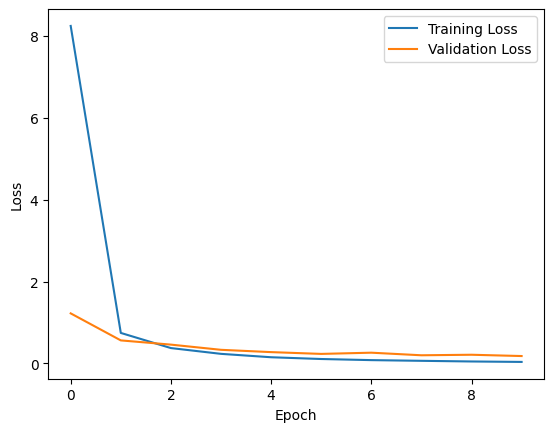

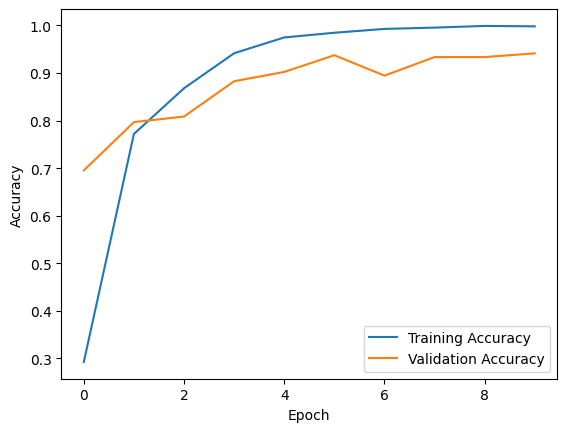

In [6]:
import numpy as np
#оценка метрик
test_steps = test_generator.samples // batch_size + 1  # Используйте +1 для учета остаточных изображений
evaluation = model.evaluate_generator(test_generator, steps=test_steps)
print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])

#предсказание классов
test_steps = test_generator.samples // batch_size
predictions = model.predict_generator(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

print("Classification Report:")
print(classification_report(true_classes[:len(predicted_classes)], predicted_classes))

print("Confusion Matrix:")
print(confusion_matrix(true_classes[:len(predicted_classes)], predicted_classes))


#отрисовка кривых обучающей и тестовой ошибок
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Сохранение чекпойнта модели

In [7]:
model.save('font_model.h5')

# Консольное приложение 

> pip install virtualenv

> virtualenv venv

> source venv/bin/activate

> pip install tensorflow numpy

> pip install Pillow

> python3 font.py font_model.h5 test.png

> deactivate